In [1]:
!git clone https://github.com/google/style-aligned

Cloning into 'style-aligned'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 110 (delta 25), reused 21 (delta 21), pack-reused 81 (from 1)
Receiving objects: 100% (110/110), 15.87 MiB | 18.10 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [2]:
import sys
from pathlib import Path

repo_dir = Path("style-aligned")
sys.path.append(str(repo_dir.resolve()))

import torch
import math
import itertools

from diffusers import StableDiffusionXLPipeline, DDIMScheduler
import sa_handler

# Новый раздел

In [3]:
scheduler = DDIMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
)

pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
    scheduler=scheduler,
).to("cuda")

pipe.enable_vae_slicing()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

vae_1_0/diffusion_pytorch_model.fp16.saf(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


In [4]:
handler = sa_handler.Handler(pipe)

def run_sa(prompts, sa_args, seed=0, num_inference_steps=30, guidance_scale=7.5):
    g = torch.Generator(device="cpu")
    g.manual_seed(int(seed))
    handler.register(sa_args)
    images = pipe(
        prompts,
        generator=g,
        num_inference_steps=int(num_inference_steps),
        guidance_scale=float(guidance_scale),
    ).images
    handler.remove()
    return images


In [7]:
base_prompts = [
    "a toy train",
    "a toy airplane",
    # "a toy bicycle",
    # "a toy car",
    # "a toy boat",
]

style_prompt = "macro photo, 3d game asset"

prompts = [p + ", " + style_prompt for p in base_prompts]
prompts


['a toy train, macro photo, 3d game asset',
 'a toy airplane, macro photo, 3d game asset']

In [8]:
grid = {
    "share_group_norm": [False, True],
    "share_layer_norm": [False, True],
    "share_attention": [True],
    "adain_queries": [True],
    "adain_keys": [True],
    "adain_values": [False],
    "only_self_level": [0.0, 0.5],
    "shared_score_shift": [0.0, math.log(2)],
    "shared_score_scale": [1.0],
    "full_attention_share": [False],
}

keys = list(grid.keys())
values = [grid[k] for k in keys]

results = []

for combo in itertools.product(*values):
    cfg = dict(zip(keys, combo))
    sa_args = sa_handler.StyleAlignedArgs(
        share_group_norm=cfg["share_group_norm"],
        share_layer_norm=cfg["share_layer_norm"],
        share_attention=cfg["share_attention"],
        adain_queries=cfg["adain_queries"],
        adain_keys=cfg["adain_keys"],
        adain_values=cfg["adain_values"],
        full_attention_share=cfg["full_attention_share"],
        shared_score_scale=cfg["shared_score_scale"],
        shared_score_shift=cfg["shared_score_shift"],
        only_self_level=cfg["only_self_level"],
    )
    images = run_sa(
        prompts,
        sa_args,
        seed=10,
        num_inference_steps=30,
        guidance_scale=7.5,
    )
    results.append((cfg, images))


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

GN=0 LN=0 only_self=0.0 shift=0.0



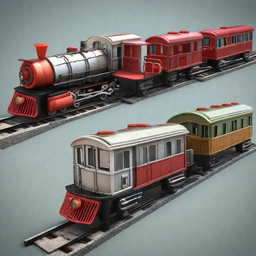
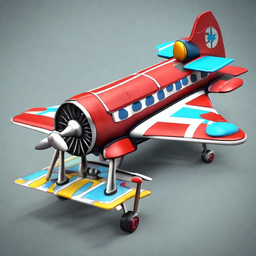

GN=0 LN=0 only_self=0.0 shift=0.693



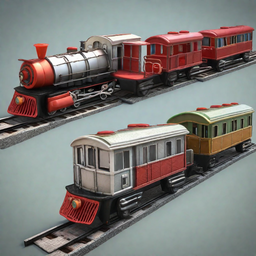
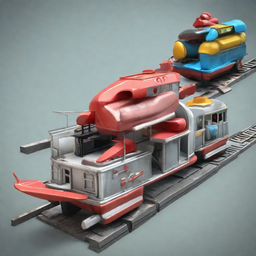

GN=0 LN=0 only_self=0.5 shift=0.0



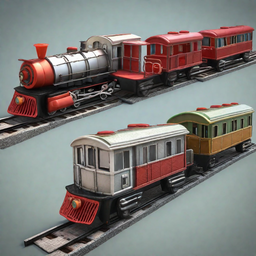
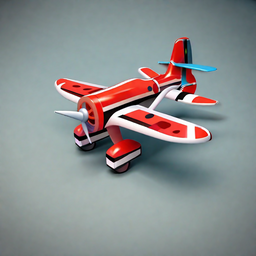

GN=0 LN=0 only_self=0.5 shift=0.693



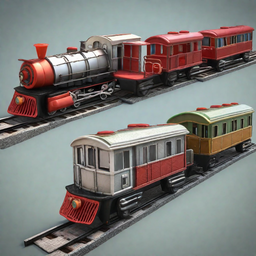
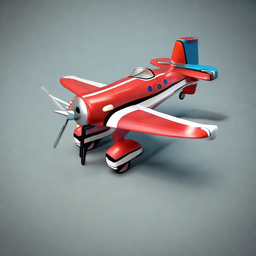

GN=0 LN=1 only_self=0.0 shift=0.0



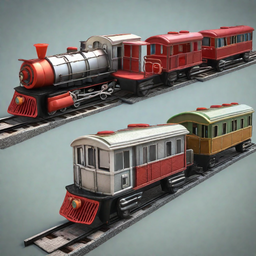
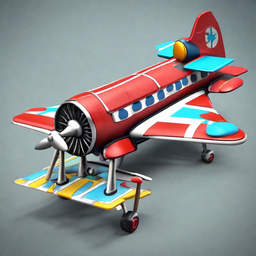

GN=0 LN=1 only_self=0.0 shift=0.693



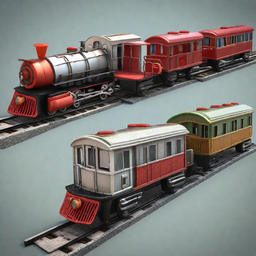
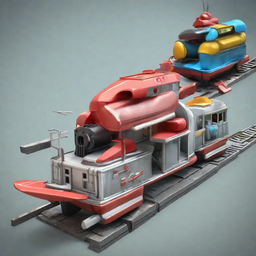

GN=0 LN=1 only_self=0.5 shift=0.0



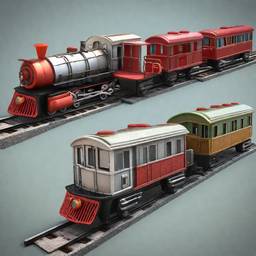
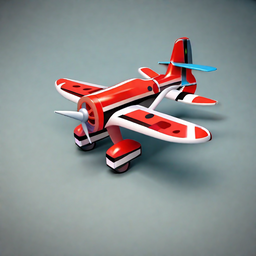

GN=0 LN=1 only_self=0.5 shift=0.693



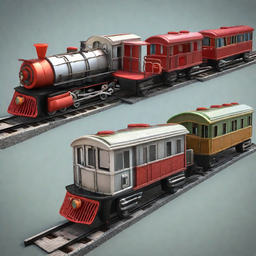
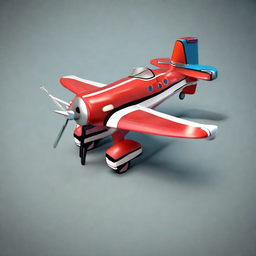

GN=1 LN=0 only_self=0.0 shift=0.0



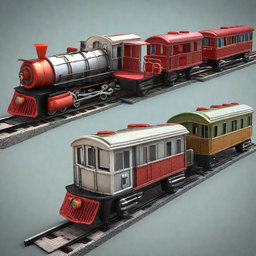
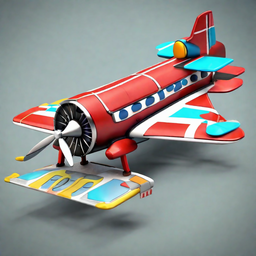

GN=1 LN=0 only_self=0.0 shift=0.693



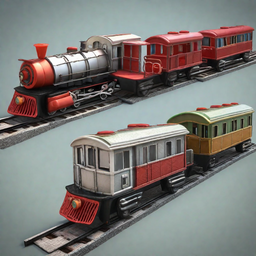
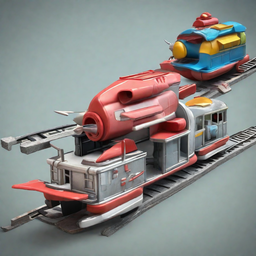

GN=1 LN=0 only_self=0.5 shift=0.0



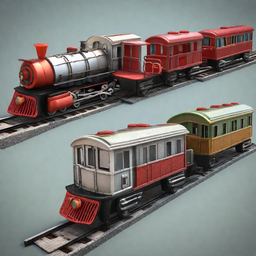
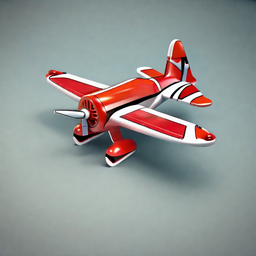

GN=1 LN=0 only_self=0.5 shift=0.693



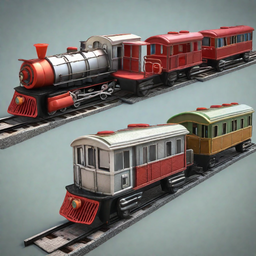
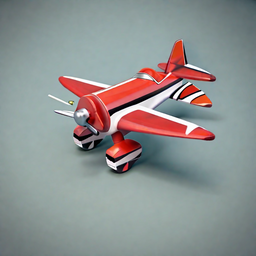

GN=1 LN=1 only_self=0.0 shift=0.0



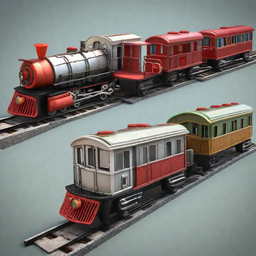
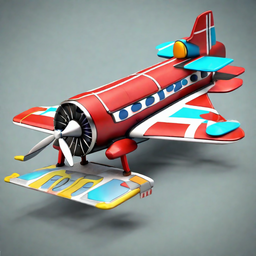

GN=1 LN=1 only_self=0.0 shift=0.693



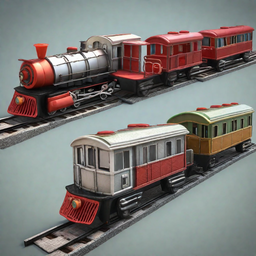
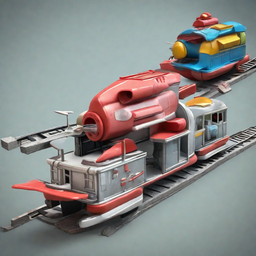

GN=1 LN=1 only_self=0.5 shift=0.0



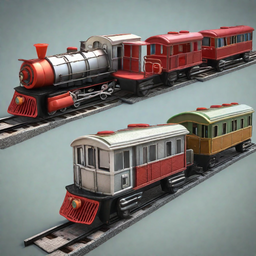
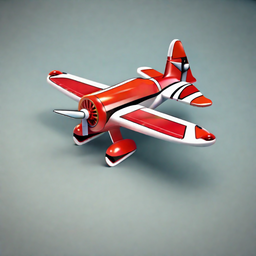

GN=1 LN=1 only_self=0.5 shift=0.693



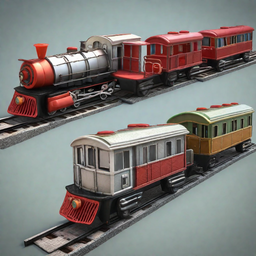
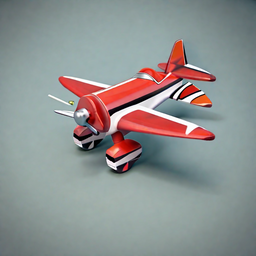

In [22]:
import mediapy as media

def cfg_to_title(cfg):
    return (
        f"GN={int(cfg['share_group_norm'])} "
        f"LN={int(cfg['share_layer_norm'])} "
        f"only_self={cfg['only_self_level']} "
        f"shift={round(cfg['shared_score_shift'],3)}"
    )

for cfg, images in results:
    titles = [cfg_to_title(cfg)] + [""] * (len(images) - 1)
    print(cfg_to_title(cfg))
    media.show_images(images, height=256, width=256, border=True)
